In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
from muon import atac as ac
from pyjaspar import jaspardb
import pychromvar as pc

In [2]:
#!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

In [3]:
mdata = mu.read_10x_h5("pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5")

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5


/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [4]:
mdata.var_names_make_unique()

### Quality control for RNA

In [5]:
# compute quality
mdata['rna'].var['mt'] = mdata['rna'].var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(mdata['rna'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# control quality
mu.pp.filter_var(mdata['rna'], 'n_cells_by_counts', lambda x: x >= 3)
mu.pp.filter_obs(mdata['rna'], 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(mdata['rna'], 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(mdata['rna'], 'pct_counts_mt', lambda x: x < 20)

### Quality control for ATAC

In [6]:
sc.pp.calculate_qc_metrics(mdata['atac'], percent_top=None, log1p=False, inplace=True)

mu.pp.filter_var(mdata['atac'], 'n_cells_by_counts', lambda x: x >= 50)
mu.pp.filter_obs(mdata['atac'], 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
mu.pp.filter_obs(mdata['atac'], 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

In [7]:
# only keep cells that pass the control for both modalities
mu.pp.intersect_obs(mdata)

### Data normalization and PCA for RNA

In [8]:
mdata['rna'].layers["counts"] = mdata['rna'].X.copy()
sc.pp.normalize_total(mdata['rna'], target_sum=1e4)
sc.pp.log1p(mdata['rna'])

sc.pp.highly_variable_genes(mdata['rna'], min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pp.scale(mdata['rna'], max_value=10)
sc.tl.pca(mdata['rna'], svd_solver='arpack')

### Normalization and LSI for ATAC

In [9]:
mdata['atac'].layers["counts"] = mdata['atac'].X
ac.pp.tfidf(mdata['atac'], scale_factor=None)
ac.tl.lsi(mdata['atac'])
mdata['atac'].obsm['X_lsi'] = mdata['atac'].obsm['X_lsi'][:,1:]
mdata['atac'].varm["LSI"] = mdata['atac'].varm["LSI"][:,1:]
mdata['atac'].uns["lsi"]["stdev"] = mdata['atac'].uns["lsi"]["stdev"][1:]

### Data integration of scRNA-seq and scATAC-seq with WNN

In [10]:
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=20)
sc.pp.neighbors(mdata['atac'], use_rep="X_lsi", n_neighbors=10, n_pcs=20)

In [11]:
# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:334: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:334: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:336: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: Ca

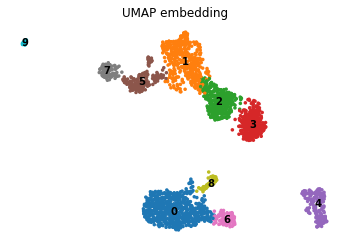

In [12]:
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

sc.tl.leiden(mdata, resolution=.3, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'], frameon=False, title="UMAP embedding", legend_loc="on data")

### Motif analysis with pychromVAR

In [13]:
mdata['atac'].X = mdata['atac'].layers["counts"]

pc.add_peak_seq(mdata, genome_file="/home/rs619065/rgtdata/hg38/genome_hg38.fa", delimiter=":|-")
pc.add_gc_bias(mdata)
pc.get_bg_peaks(mdata)

# get motifs
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

pc.match_motif(mdata, motifs=motifs)
pc.compute_deviations(mdata)

100%|██████████| 62871/62871 [00:44<00:00, 1403.92it/s]
2023-01-26 04:17:19 INFO     computing expectation reads per cell and peak...
2023-01-26 04:17:24 INFO     computing observed deviations...
2023-01-26 04:17:54 INFO     computing background deviations...


In [14]:
mdata['chromvar'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [15]:
sc.tl.rank_genes_groups(mdata['chromvar'], 'leiden_wnn', method='wilcoxon')

/home/rs619065/miniconda3/envs/r-4.1/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [16]:
pd.DataFrame(mdata['chromvar'].uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9
0,MA0736.1.GLIS2,MA1114.1.PBX3,MA1558.1.SNAI1,MA0690.1.TBX21,MA0136.2.ELF5,MA0680.1.PAX7,MA1629.1.Zic2,MA0511.2.RUNX2,MA0620.3.MITF,MA0136.2.ELF5
1,MA1491.1.GLI3,MA1649.1.ZBTB12,MA0499.2.MYOD1,MA0800.1.EOMES,MA0762.1.ETV2,MA0780.1.PAX3,MA1528.1.NFIX(var.2),MA0906.1.HOXC12,MA1139.1.FOSL2::JUNB(var.2),MA1126.1.FOS::JUN(var.2)
2,MA0696.1.ZIC1,MA1576.1.THRB(var.3),MA0258.2.ESR2,MA0688.1.TBX2,MA0611.1.Dux,MA1503.1.HOXB9,MA1628.1.Zic1::Zic2,MA0908.1.HOXD11,MA1545.1.OVOL2,MA0509.2.RFX1
3,MA0734.2.GLI2,MA1531.1.NR1D1,MA1587.1.ZNF135,MA0689.1.TBX20,MA0145.3.TFCP2,MA0908.1.HOXD11,MA0522.3.TCF3,MA1503.1.HOXB9,MA1145.1.FOSL2::JUND(var.2),MA0620.3.MITF
4,MA0697.1.ZIC3,MA0782.2.PKNOX1,MA1559.1.SNAI3,MA0802.1.TBR1,MA1420.1.IRF5,MA0083.3.SRF,MA0139.1.CTCF,MA0651.1.HOXC11,MA0799.1.RFX4,MA0776.1.MYBL1


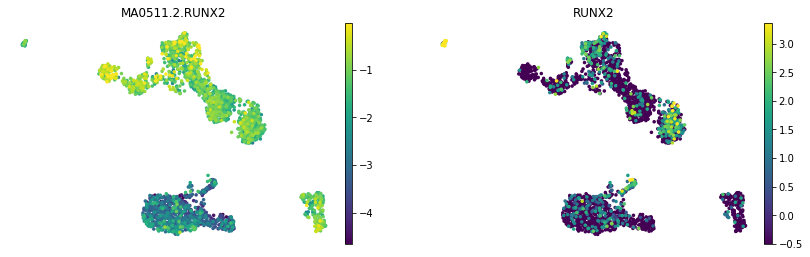

In [28]:
mu.pl.umap(mdata, color=['MA0511.2.RUNX2', 'RUNX2'], frameon=False, vmin='p1', vmax='p99')

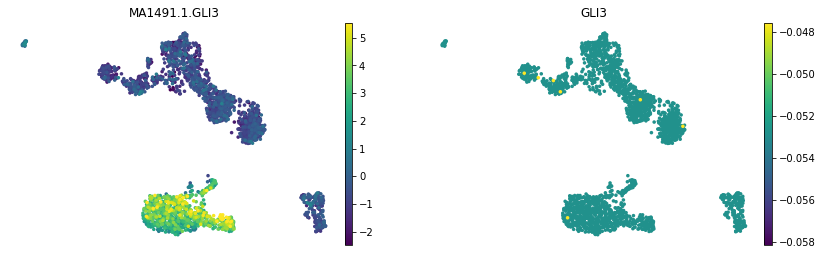

In [29]:
mu.pl.umap(mdata, color=['MA1491.1.GLI3', 'GLI3'], frameon=False, vmin='p1', vmax='p99')